In [2]:
install.packages("grf")

Installing package into 'C:/Users/Anzony/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

also installing the dependency 'DiceKriging'




package 'DiceKriging' successfully unpacked and MD5 sums checked
package 'grf' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Anzony\AppData\Local\Temp\RtmpuyjKT3\downloaded_packages


In [22]:
library(lmtest)
library(sandwich)
library(grf)
library(glmnet)
library(splines)
library(ggplot2)
library(reshape2)

In [23]:
# Read in data
data <- read.csv("https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download")
n <- nrow(data)


# Treatment: does the the gov't spend too much on "welfare" (1) or "assistance to the poor" (0)
treatment <- "w"

# Outcome: 1 for 'yes', 0 for 'no'
outcome <- "y"

# Additional covariates
covariates <- c("age", "polviews", "income", "educ", "marital", "sex")

In [24]:
# Only valid in the randomized setting. Do not use in observational settings.
Y <- data[,outcome]
W <- data[,treatment]
ate.est <- mean(Y[W==1]) - mean(Y[W==0])
ate.se <- sqrt(var(Y[W == 1]) / sum(W == 1) + var(Y[W == 0]) / sum(W == 0))
ate.tstat <- ate.est / ate.se
ate.pvalue <- 2*(pnorm(1 - abs(ate.est/ate.se)))
ate.results <- c(estimate=ate.est, std.error=ate.se, t.stat=ate.tstat, pvalue=ate.pvalue)
print(ate.results)

     estimate     std.error        t.stat        pvalue 
 -0.347115545   0.004895638 -70.903028958   0.000000000 


In [25]:
fmla <- formula(paste(outcome, '~', treatment))  # y ~ w
t.test(fmla, data=data)


	Welch Two Sample t-test

data:  y by w
t = 70.903, df = 20840, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.3375197 0.3567114
sample estimates:
mean in group 0 mean in group 1 
      0.4398290       0.0927135 


In [26]:
# Do not use! standard errors are not robust to heteroskedasticity! (See below)
fmla <- formula(paste0(outcome, '~', treatment))
ols <- lm(fmla, data=data)
coef(summary(ols))[2,]

Estimate    Std. Error       t value      Pr(>|t|) 
 -0.347115545   0.004732343 -73.349622060   0.000000000

In [27]:
# Use this instead. Standard errors are heteroskedasticity-robust.
# Only valid in randomized setting.
fmla <- formula(paste0(outcome, '~', treatment))
ols <- lm(fmla, data=data)
coeftest(ols, vcov=vcovHC(ols, type='HC2'))[2,]

Estimate    Std. Error       t value      Pr(>|t|) 
 -0.347115545   0.004895638 -70.903028958   0.000000000

In [28]:
# copying old dataset, just in case
data.exp <- data

# defining the group that we will be dropped with some high probability
grp <- ((data$w == 1) &  # if treated AND...
        (
            (data$age > 45) |     # belongs an older group OR
            (data$polviews < 5)   # more conservative
        )) | # OR
        ((data$w == 0) &  # if untreated AND...
        (
            (data$age < 45) |     # belongs a younger group OR
            (data$polviews > 4)   # more liberal
        )) 

# Individuals in the group above have a small chance of being kept in the sample
prob.keep <- ifelse(grp, .15, .85)
keep.idx <- as.logical(rbinom(n=nrow(data), prob=prob.keep, size = 1))

# Dropping
data <- data[keep.idx,]

In [34]:
w

[1] 1

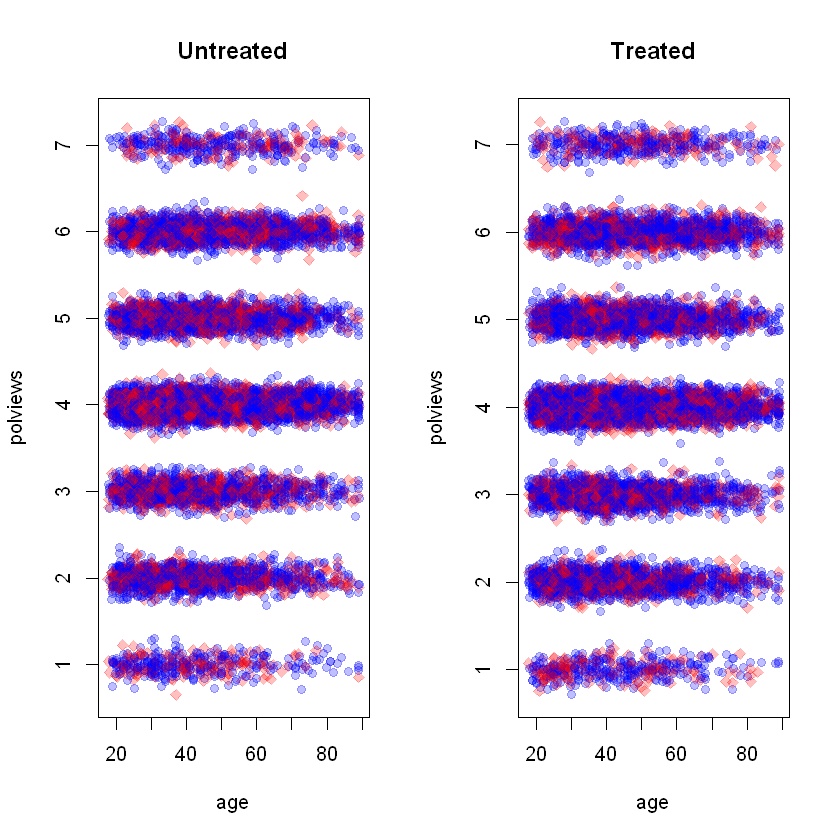

In [32]:
X <- model.matrix(formula("~ 0 + age + polviews"), data.exp)  # old 'experimental' dataset
W <- data.exp$w
Y <- data.exp$y
par(mfrow=c(1,2))
for (w in c(0, 1)) {
  plot(X[W==w,1] + rnorm(n=sum(W==w), sd=.1), X[W==w,2] + rnorm(n=sum(W==w), sd=.1), 
       pch=ifelse(Y, 23, 21), cex=1, col=ifelse(Y, rgb(1,0,0,1/4), rgb(0,0,1,1/4)),
       bg=ifelse(Y, rgb(1,0,0,1/4), rgb(0,0,1,1/4)), 
       main=ifelse(w, "Treated", "Untreated"), xlab="age", ylab="polviews")
}

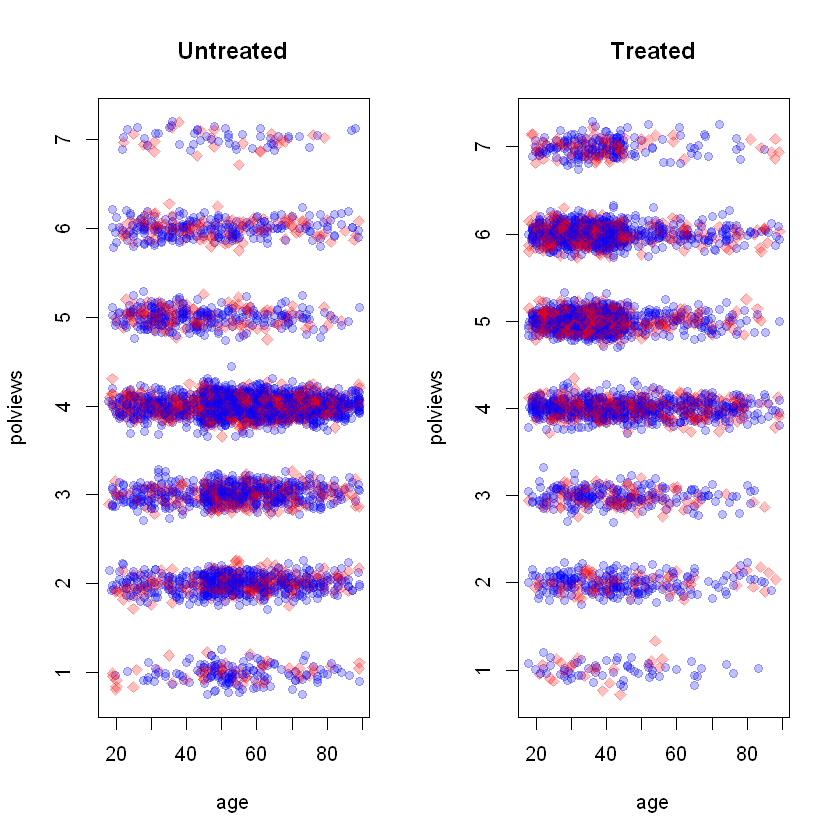

In [36]:
X <- model.matrix(formula("~ 0 + age + polviews"), data)
W <- data$w
Y <- data$y
par(mfrow=c(1,2))
for (w in c(0, 1)) {
  plot(X[W==w,1] + rnorm(n=sum(W==w), sd=.1), X[W==w,2] + rnorm(n=sum(W==w), sd=.1), 
       pch=ifelse(Y, 23, 21), cex=1, col=ifelse(Y, rgb(1,0,0,1/4), rgb(0,0,1,1/4)),
       bg=ifelse(Y, rgb(1,0,0,1/4), rgb(0,0,1,1/4)), main=ifelse(w, "Treated", "Untreated"), xlab="age", ylab="polviews")
}

In [37]:
# Do not use in observational settings.
# This is only to show how the difference-in-means estimator is biased in that case.
fmla <- formula(paste0(outcome, '~', treatment))
ols <- lm(fmla, data=data)
coeftest(ols, vcov=vcovHC(ols, type='HC2'))[2,]

Estimate     Std. Error        t value       Pr(>|t|) 
 -2.956229e-01   8.710487e-03  -3.393873e+01  1.630263e-237

In [39]:
# Do not use! We'll see a better estimator below.

# Fitting some model of E[Y|X,W]
fmla <- as.formula(paste0(outcome, "~ ", paste("bs(", covariates, ", df=3)", "*", treatment, collapse="+")))
model <- lm(fmla, data=data)  

# Predicting E[Y|X,W=w] for w in {0, 1}
data.1 <- data
data.1[,treatment] <- 1
data.0 <- data
data.0[,treatment] <- 0
muhat.treat <- predict(model, newdata=data.1)
muhat.ctrl <- predict(model, newdata=data.0)

# Averaging predictions and taking their difference
ate.est <- mean(muhat.treat) - mean(muhat.ctrl)
print(ate.est)

Warning message in predict.lm(model, newdata = data.1):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(model, newdata = data.0):
"prediction from a rank-deficient fit may be misleading"


[1] -0.3564408


In [125]:
attributes(model)

$names
 [1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"        

$class
[1] "lm"

In [122]:
predict(model, newdata=data.0)

Warning message in predict.lm(model, newdata = data.0):
"prediction from a rank-deficient fit may be misleading"


1            4           17           18           21           23 
 0.464723630  0.137259844  0.434382249  0.657490434  0.488753119  0.649152930 
          28           30           31           32           35           49 
 0.492290383  0.578255999  0.378637846  0.315891068  0.257057989  0.540235556 
          52           54           58           62           66           69 
 0.635078298  0.530894387  0.511394001  0.439569462  0.385217760  0.434692191 
          73           78           82           88           97          101 
 0.438101057  0.506550096  0.670678886  0.271208949  0.555286005  0.498125273 
         104          107          108          112          113          114 
 0.563468290  0.487311022  0.530286825  0.560298864  0.435840736  0.579470861 
         115          116          121          122          123          126 
 0.558445452  0.285911395  0.486477725  0.338086416  0.483098033  0.458353608 
         128          130          133          144          151          152 
 0.608158169  0.467850649  0.551699670  0.544011886  0.322987859  0.499161724 
         156          159          160          171          173          176 
 0.262439743  0.626886035  0.418294164  0.279146086  0.450949448  0.625331472 
         182          189          195          196          203          205 
 0.455224304  0.393279285  0.520386705  0.486395393  0.449855082  0.419657934 
         210          214          217          218          221          223 
 0.487311022  0.671760926  0.656720751  0.732661211  0.711181258  0.373707071 
         226          230          237          251          253          255 
 0.502879693  0.687026609  0.237242556  0.279823919  0.579324903  0.405906186 
         261          265          270          271          274          275 
 0.253252261  0.597601447  0.483098033  0.491631726  0.476387832  0.551242317 
         277          279          281          282          286          287 
 0.333171047  0.214564300  0.240308435  0.485348845  0.462268871  0.407900227 
         292          293          297          300          302          319 
 0.449264816  0.644165634  0.248358621  0.674547674  0.377421782  0.286036762 
         323          324          328          330          332          333 
 0.485197973  0.449319209  0.417334252  0.626886035  0.385984479  0.366243936 
         338          341          343          345          347          350 
 0.417653359  0.478188103  0.457152066  0.342863727  0.544122732  0.629049981 
         353          354          355          356          361          362 
 0.566227307  0.514236200  0.585306144  0.184373146  0.488368651  0.222983749 
         367          369          375          381          382          391 
 0.472940356  0.271478692  0.489271799  0.365399718  0.186112152  0.299581311 
         393          395          403          405          407          408 
 0.624588682  0.465752288  0.130177593  0.498235650  0.468518732  0.612747461 
         410          411          425          426          431          432 
 0.457379947  0.534869662  0.454886970  0.470253490  0.506473929  0.594750715 
         433          436          437          443          448          455 
 0.679045337  0.715147441  0.181065959  0.597685653  0.369154122  0.463305709 
         457          463          464          466          468          469 
 0.555276026  0.381157750  0.242280849  0.482020889  0.548600955  0.512704480 
         475          476          480          481          482          484 
 0.154043473  0.419221980  0.624590669  0.478536809  0.437160278  0.529307638 
         485          489          491          493          494          499 
 0.635745768  0.364952012  0.551699670  0.498196622  0.567202562  0.432764609 
         501          502          505          507          509          512 
 0.675875911  0.494031693  0.511223338  0.292492908  0.367717351  0.352685250 
         516          517          518          523          

In [120]:
as.matrix(model$coef)

(Intercept),0.1728730561
"bs(age, df = 3)1",-0.0022959135
"bs(age, df = 3)2",-0.0469574389
"bs(age, df = 3)3",-0.1254818410
w,0.1261832891
"bs(polviews, df = 3)1",-0.0003710307
"bs(polviews, df = 3)2",0.2990703401
"bs(polviews, df = 3)3",0.3563277869
"bs(income, df = 3)1",-0.0329599583
"bs(income, df = 3)2",0.2068051812
"bs(income, df = 3)3",0.2009103030


### Save data to python

In [59]:
# get same dataframe for ols.cl
X <- as.data.frame( model.matrix(model) )

no_col <- attributes(model$coefficients)$names[is.na(model$coefficients)]

X1  <- X[, -which(names( X ) %in% no_col ) ]
X1$y = data$y


save( X1 , file = "../data/model_data.RData")

In [81]:
model


Call:
lm(formula = fmla, data = data)

Coefficients:
            (Intercept)         bs(age, df = 3)1         bs(age, df = 3)2  
               0.172873                -0.002296                -0.046957  
       bs(age, df = 3)3                        w    bs(polviews, df = 3)1  
              -0.125482                 0.126183                -0.000371  
  bs(polviews, df = 3)2    bs(polviews, df = 3)3      bs(income, df = 3)1  
               0.299070                 0.356328                -0.032960  
    bs(income, df = 3)2      bs(income, df = 3)3        bs(educ, df = 3)1  
               0.206805                 0.200910                -0.073463  
      bs(educ, df = 3)2        bs(educ, df = 3)3     bs(marital, df = 3)1  
               0.158344                -0.190878                 0.043448  
   bs(marital, df = 3)2     bs(marital, df = 3)3         bs(sex, df = 3)1  
              -0.125843                -0.048526                       NA  
       bs(sex, df = 3)2         bs

In [88]:
rbinom(100, 1, .05)

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [89]:
school <- sample(c("A", "B"), p=c(.5, .5), size=100, replace=TRUE)

In [91]:
treated <- ifelse(school == 'A', rbinom(100, 1, .05), rbinom(100, 1, .4))

In [102]:
length(school == "A")

[1] 100

In [103]:
length(rbinom(100, 1, .05))

[1] 100

In [113]:
mean(sample.means[101:200])

[1] 68.79103

In [114]:
mean(sample.means[1:100])

[1] 68.7234

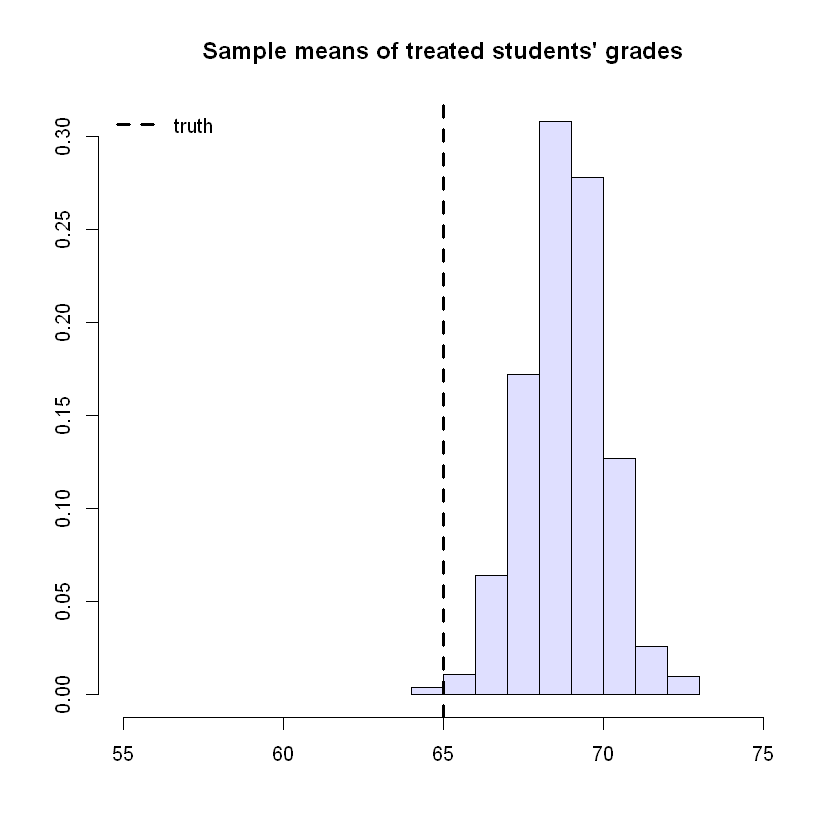

In [79]:
# Simulating the scenario above a large number of times
A.mean <- 60
B.mean <- 70
pop.mean <- .5 * A.mean + .5 * B.mean  # both schools have the same size

# simulating the scenario about a large number of times
sample.means <- replicate(1000, {
    school <- sample(c("A", "B"), p=c(.5, .5), size=100, replace=TRUE)
    treated <- ifelse(school == 'A', rbinom(100, 1, .05), rbinom(100, 1, .4))
    grades <- ifelse(school == 'A', rnorm(100, A.mean, 5), rnorm(100, B.mean, 5))
    mean(grades[treated == 1])  # average grades among treated students, without taking school into account
  })
hist(sample.means, freq=F, main="Sample means of treated students' grades", xlim=c(55, 75), col=rgb(0,0,1,1/8), ylab="", xlab="")
abline(v=pop.mean, lwd=3, lty=2)
legend("topleft", "truth", lwd=3, lty=2, bty="n")

In [117]:
agg.means

[1] 69.23282 63.70922 66.50361 65.02270 64.68825 64.30042      NaN 68.54060
   [9] 63.85105 61.93757 65.27485 64.94574 63.69145 68.17974 65.55123 66.38448
  [17] 66.16705 63.27884 62.35178 63.40813 64.86521 64.03531      NaN 65.49370
  [25] 64.98573 60.70271 66.91389 62.37843 64.09238 65.41088 64.15449 63.02700
  [33] 66.63216 65.48666 67.81069 62.96688 70.22585      NaN 64.56660 62.54947
  [41] 65.04415 62.95503 65.70446      NaN 64.14989 67.89752 64.50821      NaN
  [49] 64.81424 67.79414 64.71092 63.97357 64.30514 64.96122      NaN 65.83164
  [57] 69.11668 64.44518 66.27325 64.11574 65.35135 64.58203 64.04493 68.96511
  [65] 64.96554 64.27588 62.28013 68.34613 65.43616      NaN 62.97287 63.61134
  [73] 65.94804 58.84431 66.24803 68.13584 64.57117      NaN 63.59737 65.26012
  [81] 66.97083 65.35417 64.24269 64.39871 66.31267 66.35754 67.06267 65.88319
  [89] 63.33714 63.06610 64.68578 66.01660      NaN 63.65437 66.30010 66.69784
  [97] 67.77613 64.23353 65.52285 66.51283 65.74200 65.78906 65.93527 65.80609
 [105] 66.59000 65.60943 64.59644 66.09386 64.71933 62.94401 67.67054 62.34516
 [113]      NaN 63.51866 66.39556      NaN 64.61233 64.13817 63.58258 62.26267
 [121] 65.87881 65.03379      NaN 66.19789 66.52860 64.19065 64.68525      NaN
 [129] 67.49899 64.15260 63.35501 66.57575 67.00661 64.67707 68.98805      NaN
 [137] 67.59349 63.49026 64.66382 65.53678 64.15918 63.24722 63.48158 62.64915
 [145] 64.79579      NaN 66.78478      NaN 61.24214 66.39570 63.40262 64.23264
 [153] 64.70734 69.20111 67.40518 61.25834 64.31097 64.36791 66.62240      NaN
 [161] 63.33064 64.72427 59.72164 61.97830 65.06461 62.29343 66.75501 64.82969
 [169] 67.02799 64.19927 64.16129 66.27427 68.46458 64.55686 63.79850 65.04964
 [177] 63.98073 65.58483 65.21253 67.03923 67.68924      NaN 66.00717 67.06614
 [185] 68.75301 68.29730 64.08106 61.72980 64.90863 64.66619 67.68367 63.43170
 [193] 64.44715 64.29436      NaN 60.99746 66.46902 65.51154 62.40327 66.31591
 [201] 67.13291 65.30646 65.45298 63.35083 64.28993 63.48962 61.97934 65.37171
 [209]      NaN 66.11301 67.39768 65.64141 63.07412 61.65326      NaN 64.26098
 [217] 65.90687 68.86930 65.84298 67.07454 66.16122 68.60385 64.70878 59.81375
 [225] 70.00226 62.66192 65.62948 63.59549 63.48878 64.44633 65.78604 65.09836
 [233] 65.06388 66.01967      NaN 62.53309 67.13989 64.36121      NaN 63.74824
 [241] 69.01777 71.73265 62.85072 63.61702 64.86912 64.76251 64.11036      NaN
 [249] 65.96379 63.35779 67.92390      NaN 61.48469 67.76430      NaN 62.96028
 [257] 65.10417 64.61290 64.24576 65.93531 66.11842 64.81490      NaN 62.89894
 [265] 63.88214 65.95196 65.15261 65.73535 65.05790      NaN      NaN 61.67212
 [273] 63.52209 67.61035 64.94346 64.93774      NaN 65.22817 62.54932 66.54935
 [281] 66.51283 63.07880 67.33981 65.72589 69.03372 65.42999      NaN 64.99342
 [289] 66.75276 65.25725      NaN 65.26919 66.70021      NaN 66.11006 69.78262
 [297]      NaN 64.50096 66.08081 67.44950 64.88344 67.15373 65.20438 59.49761
 [305] 66.79528 61.16208 65.59784 63.08096 65.97371 66.06569 62.62442 64.94110
 [313] 64.53359      NaN 64.88270 63.23171 64.83772 65.19448 63.82345      NaN
 [321] 67.45554 65.43141 66.23909 65.83399 63.39434 65.69980 67.63569 68.26426
 [329] 64.19379 62.65490 63.25628      NaN 64.26330 64.80232 64.57223 60.47143
 [337] 63.76746 62.74164 62.34317 64.58123 65.41979 65.75928 64.40852 64.63701
 [345]      NaN 65.01638 60.67889 65.12824 63.27605 63.09431 63.93452 63.27124
 [353] 64.10542 64.71111 66.58439 64.93781 61.17095 66.30511 65.17517 68.47015
 [361] 64.53499 64.35165 66.24105 65.03366 64.48060 61.42871 65.03829 66.67183
 [369] 68.38451 66.96753 64.90759 63.88230 63.76917 66.88235 65.51192 66.39754
 [377] 66.05211      NaN 61.78510      NaN 62.82397 64.54011 63.41940 60.84105
 [385]      NaN 65.72514 64.04140 60.18241 62.75235 65.62506 64.61623 64.54151
 [393] 63.52537 63.33518 63.61450 67.20385 65.30539 65.22741 61.69370 66.59759
 [401] 64.13166 64.67008 64.65091 65.51521 66.75900  

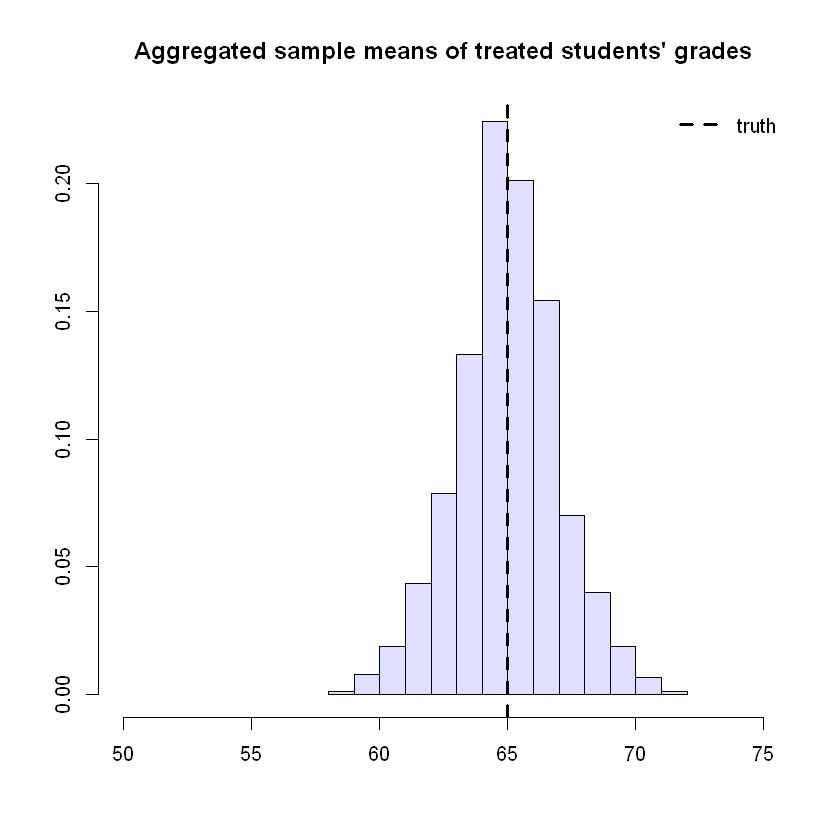

In [116]:
# simulating the scenario about a large number of times
agg.means <- replicate(1000, {
    school <- sample(c("A", "B"), p=c(.5, .5), size=100, replace=TRUE)
    treated <- ifelse(school == 'A', rbinom(100, 1, .05), rbinom(100, 1, .4))
    grades <- ifelse(school == 'A', rnorm(100, A.mean, 5), rnorm(100, B.mean, 5))
    # average grades among treated students in each school
    mean.treated.A <- mean(grades[(treated == 1) & (school == 'A')])
    mean.treated.B <- mean(grades[(treated == 1) & (school == 'B')])
    # probability of belonging to each school
    prob.A <- mean(school == 'A')
    prob.B <- mean(school == 'B')
    prob.A * mean.treated.A + prob.B * mean.treated.B
  })
hist(agg.means, freq=F, main="Aggregated sample means of treated students' grades", xlim=c(50, 75), col=rgb(0,0,1,1/8), ylab="", xlab="")
abline(v=pop.mean, lwd=3, lty=2)
legend("topright", "truth", lwd=3, lty=2, bty="n")

In [126]:
# Available in randomized settings and observational settings with unconfoundedness+overlap

# Estimate the propensity score e(X) via logistic regression using splines
fmla <- as.formula(paste0("~", paste0("bs(", covariates, ", df=3)", collapse="+")))
W <- data[,treatment]
Y <- data[,outcome]
XX <- model.matrix(fmla, data)
logit <- cv.glmnet(x=XX, y=W, family="binomial")
e.hat <- predict(logit, XX, s = "lambda.min", type="response")

# Using the fact that
z <- Y * (W/e.hat - (1-W)/(1-e.hat))
ate.est <- mean(z)
ate.se <- sd(z) / sqrt(length(z))
ate.tstat <- ate.est / ate.se
ate.pvalue <- 2*(pnorm(1 - abs(ate.est/ate.se)))
ate.results <- c(estimate=ate.est, std.error=ate.se, t.stat=ate.tstat, pvalue=ate.pvalue)
print(ate.results)

      estimate      std.error         t.stat         pvalue 
 -3.513863e-01   1.454062e-02  -2.416584e+01  1.006671e-118 


In [127]:
fmla

~bs(age, df = 3) + bs(polviews, df = 3) + bs(income, df = 3) + 
    bs(educ, df = 3) + bs(marital, df = 3) + bs(sex, df = 3)